In [1]:
import socket

host = "localhost"
port = 5432

sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
result = sock.connect_ex((host, port))
if result == 0:
    print(f"Connection to {host}:{port} successful!")
else:
    print(f"Failed to connect to {host}:{port}")
sock.close()



Connection to localhost:5432 successful!


In [2]:


import pandas as pd 
from sqlalchemy import create_engine

DB_HOST="localhost"  
DB_PORT="5432"
DB_NAME="otodom"
DB_USER="postgres"
DB_PASSWORD="postgres"

engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

df = pd.read_sql("SELECT * FROM listings", engine)
df.head()


,id,price,district,rooms,area,seller_type
0,1,1199000.0,Grunwald,3,63.54,Oferta prywatna
1,2,405000.0,Stare Miasto,2,30.00,Oferta prywatna
2,3,679000.0,Stare Miasto,4,64.90,Oferta prywatna
3,4,425000.0,Stare Miasto,1,29.20,Biuro nieruchomości
4,5,650000.0,Stare Miasto,3,53.00,Oferta prywatna


In [3]:
df.isnull().sum()
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           570 non-null    int64  
 1   price        454 non-null    float64
 2   district     570 non-null    object 
 3   rooms        570 non-null    int64  
 4   area         570 non-null    float64
 5   seller_type  468 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 26.8+ KB


,id,price,district,rooms,area,seller_type
0,1,1199000.0,Grunwald,3,63.54,Oferta prywatna
1,2,405000.0,Stare Miasto,2,30.00,Oferta prywatna
2,3,679000.0,Stare Miasto,4,64.90,Oferta prywatna
3,4,425000.0,Stare Miasto,1,29.20,Biuro nieruchomości
4,5,650000.0,Stare Miasto,3,53.00,Oferta prywatna


## Preview & Clean the Data

I removed rows where `rooms` or `area` is missing. 


Average price per square meter: 12229.79 PLN/sqm
Median price per square meter: 12264.15 PLN/sqm


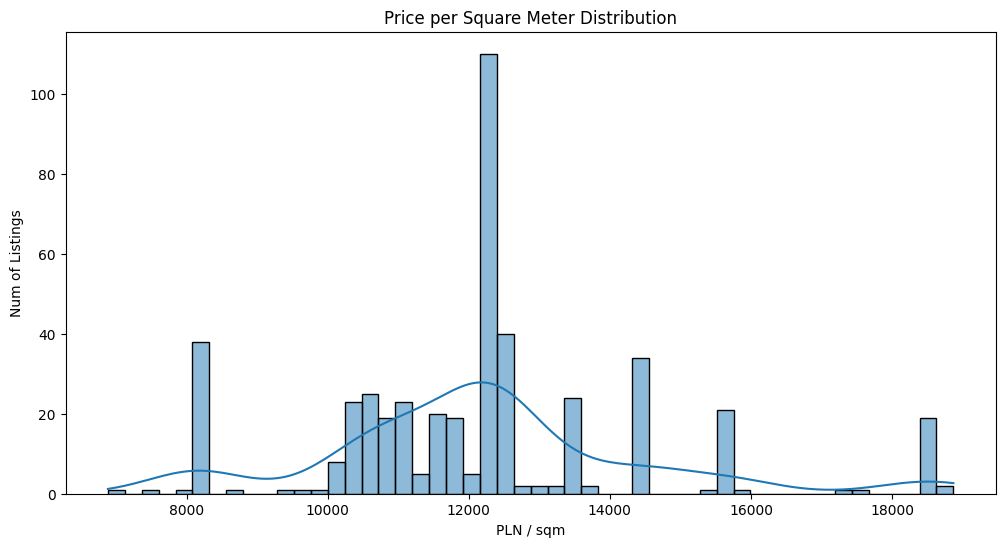

In [4]:
df_clean = df.dropna(subset=['rooms', 'area'])
df_clean = df_clean[(df_clean['rooms'] > 0) & (df_clean['area'] > 0)]

df_clean["price_per_sqm"] = (df_clean["price"] / df_clean["area"]).round(2)
df_clean.head()
avg_price_per_sqm = df_clean['price_per_sqm'].mean().round(2)
print(f"Average price per square meter: {avg_price_per_sqm} PLN/sqm")
median_price_per_sqm = df_clean['price_per_sqm'].median().round(2)
print(f"Median price per square meter: {median_price_per_sqm} PLN/sqm")

# visualization

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(df_clean['price_per_sqm'], bins=50, kde=True)
plt.title('Price per Square Meter Distribution')
plt.xlabel('PLN / sqm')
plt.ylabel('Num of Listings')
plt.show()

## District analysis

In [5]:
df_clean = df_clean[df_clean['price_per_sqm'].notna() & df_clean['price_per_sqm'].apply(lambda x: x != float('inf'))]
district_stats = df_clean.groupby('district').agg({
    'price_per_sqm' : 'mean',
    'area' : 'mean',
    'id' : 'count'
}).rename(columns={'id' : 'listings_count'})
district_stats = district_stats.round(2)
district_stats.sort_values(by='price_per_sqm', ascending=False, inplace=True)
district_stats 



,price_per_sqm,area,listings_count
district,,,
Stare Miasto,14471.59,39.41,86
Wilda,14063.74,38.42,41
Jeżyce,11877.78,53.09,182
Grunwald,11227.63,71.04,72
Nowe Miasto,10424.79,50.12,73


## DISTRICT LEVEL ANALYSIS

District level analysis show:



## Seller type by district

In [6]:
seller_type_stats = df_clean.groupby(['district', 'seller_type']).size().unstack(fill_value=0)

# normalize the counts to get percentages
seller_type_stats = seller_type_stats.div(seller_type_stats.sum(axis=1), axis=0) * 100
seller_type_stats = seller_type_stats.round(2)
seller_type_stats = seller_type_stats.fillna(0)
seller_type_stats



seller_type,Biuro nieruchomości,Deweloper,Oferta prywatna
district,,,
Grunwald,55.88,0.00,44.12
Jeżyce,94.48,0.00,5.52
Nowe Miasto,93.15,1.37,5.48
Stare Miasto,41.86,0.00,58.14
Wilda,39.02,0.00,60.98


## Seller type by district

The distribution of seller types across districts reveals notable patterns:

- 
- 

## Seller type distribution - visualization

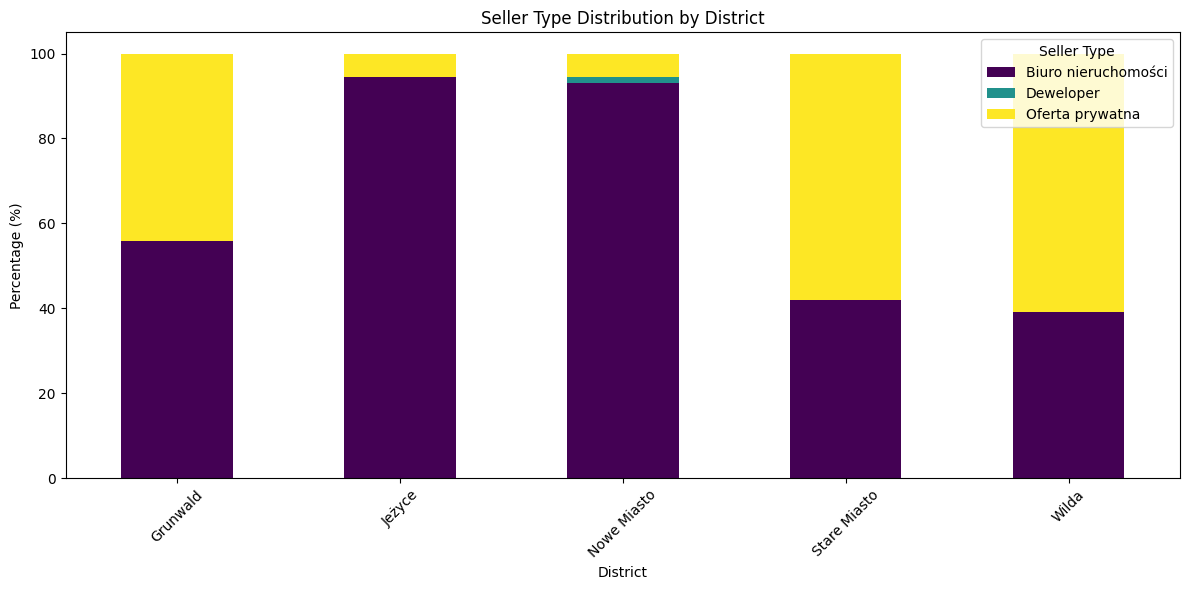

In [7]:
plt.figure(figsize=(12, 6))
seller_type_stats.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca(),figsize=(12, 6))
plt.title('Seller Type Distribution by District')
plt.xlabel('District')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.legend(title='Seller Type')
plt.tight_layout()
plt.show()

## Linear regression

In [8]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Mapping district distances from the city centre (in km)
district_distances = {
    'Jeżyce': 3.5,
    'Wilda': 4.0,
    'Nowe Miasto': 2.5,
    'Stare Miasto': 0.5,
    'Grunwald': 5.0,
    'Łazarz': 3.0,
}
df_clean['distance_km'] = df_clean['district'].map(district_distances)

# Dropping rows with missing values in important columns
df_clean = df_clean[['rooms', 'area', 'seller_type', 'district', 'price', 'distance_km']].dropna()

# Converting district into binary columns to use in regression
df_encoded = pd.get_dummies(df_clean, columns=['district'], drop_first=True)

# Adding polynomial term for area (area squared)  -- modification of the linear model
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_area = poly.fit_transform(df_encoded[['area']])
df_encoded['area'] = poly_area[:, 0] 
df_encoded['area_sq'] = poly_area[:, 1] 

# Adding interaction terms between area and districts -- modification of the linear model
district_cols = [col for col in df_encoded.columns if col.startswith('district_')]

for col in district_cols:
    df_encoded[f'area_{col}'] = df_encoded['area'] * df_encoded[col]

feature_cols = ['area', 'area_sq', 'distance_km'] + district_cols + [f'area_{col}' for col in district_cols]

X = df_encoded[feature_cols]
y = df_encoded['price']

# Scaling features to standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fitting linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
cv = (rmse * 100 / np.mean(y)).round(2)

print(f"Coefficient of variation: {cv}%")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Coefficients and intercept
coefficients = pd.Series(model.coef_, index=feature_cols)
print("Coefficients:")
print((coefficients.sort_values(ascending=False)).round(2))

intercept = model.intercept_
print(f"Intercept: {intercept:.2f}")


Coefficient of variation: 15.25%
Root Mean Squared Error: 90896.01
R^2 Score: 0.83
Coefficients:
area                          236455.90
area_district_Nowe Miasto     169379.20
district_Stare Miasto          74525.21
area_district_Jeżyce           61891.43
area_district_Wilda            38776.01
distance_km                    28708.35
district_Wilda                -14611.83
area_district_Stare Miasto    -16689.43
district_Jeżyce               -25772.90
area_sq                       -51470.22
district_Nowe Miasto         -162330.29
dtype: float64
Intercept: 594407.89


In [9]:
# Variable relevance
import statsmodels.api as sm

# Converting boolean columns to int for statsmodels compatibility
X_sm_int = sm.add_constant(X.astype(float))
model_sm = sm.OLS(y, X_sm_int).fit()
print(model_sm.summary())



                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     324.1
Date:                Tue, 09 Sep 2025   Prob (F-statistic):          2.28e-195
Time:                        17:27:03   Log-Likelihood:                -5678.5
No. Observations:                 449   AIC:                         1.138e+04
Df Residuals:                     438   BIC:                         1.142e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

## TESTING 1

In [10]:
from statsmodels.stats.stattools import durbin_watson

from scipy.stats import pearsonr


residuals = model_sm.resid

# Lagged residuals (shift by 1)
residuals_lagged = residuals.shift(1)

# Drop the first NA (because of lag)
valid_idx = residuals_lagged.notna()

# Calculate Pearson correlation between residuals and lagged residuals
corr, p_value = pearsonr(residuals[valid_idx], residuals_lagged[valid_idx])

print(f"Pearson correlation between residuals and their lagged values: {corr:.3f}")
print(f"P-value: {p_value:.4e}")

# Calculate the number of regressors (k)
k = X_sm_int.shape[1] - 1  # subtract 1 for intercept
print(f"Number of regressors (k): {k}")

# Calculate the Durbin-Watson statistic
dw_stat = durbin_watson(model_sm.resid)
print(f"Durbin-Watson statistic: {dw_stat:.3f}")


Pearson correlation between residuals and their lagged values: -0.068
P-value: 1.5025e-01
Number of regressors (k): 11
Durbin-Watson statistic: 2.031


## AUTOCORRELATION OF THE RESIDUALS

Pearson correlation suggests that the residuals are not correlated. P-value is > than 0.05 so I cannot reject the null hypothesis of autocorrelation. 

The Durbin-Watson statistic (2.031) also points so no anutocorrelation.

# Overall

There is no significant autocorrelation of the residuals in the model.

## TESTING 2

Testing for heteroscedasticity

{'Test Statistic': np.float64(273.67513993359074), 'Test Statistic p-value': np.float64(1.8518049223615847e-46), 'F-Statistic': np.float64(54.205888662201275), 'F-Test p-value': np.float64(1.236072293816291e-92)}


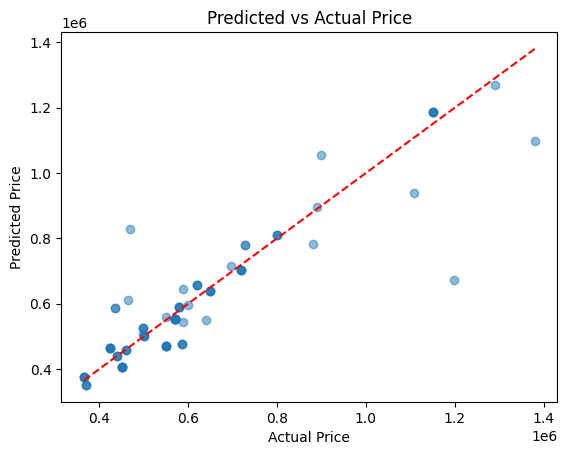

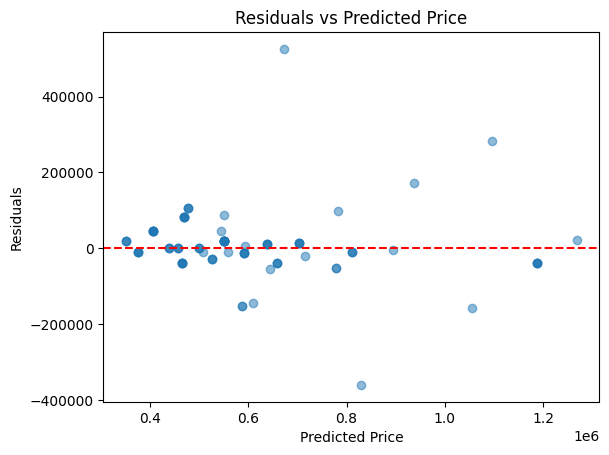

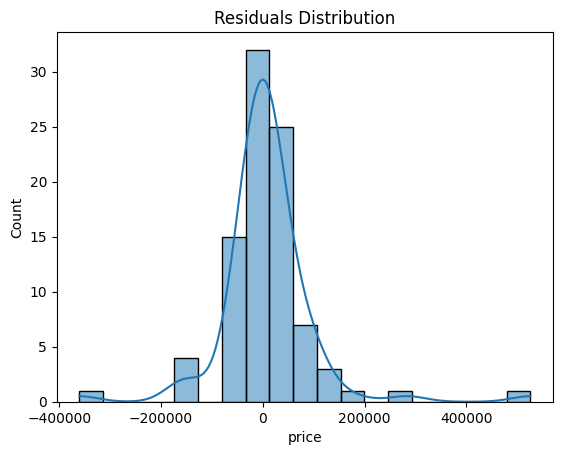

In [11]:
import matplotlib.pyplot as plt

from statsmodels.stats.diagnostic import het_white

# Fit linear regression model with statsmodels to get residuals and design matrix
X_sm = sm.add_constant(X_train)  # add intercept
model_sm = sm.OLS(y_train, X_sm).fit()

# Get residuals
residuals = model_sm.resid

# Perform White's test
white_test = het_white(residuals, model_sm.model.exog)

labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test)))

plt.scatter(y_test, model.predict(X_test), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Price")
plt.show()

residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Price")
plt.show()

import seaborn as sns

sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()





## FIXING HETERSOSCEDASTICITY OF THE RESIDUALS

The linear model modified with interaction and polynomial terms show heteroscedasticity with White's test. I will attempt to correct it with WLS.

                            WLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.996
Model:                            WLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.229e+04
Date:                Tue, 09 Sep 2025   Prob (F-statistic):               0.00
Time:                        17:50:41   Log-Likelihood:                -158.81
No. Observations:                 449   AIC:                             339.6
Df Residuals:                     438   BIC:                             384.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

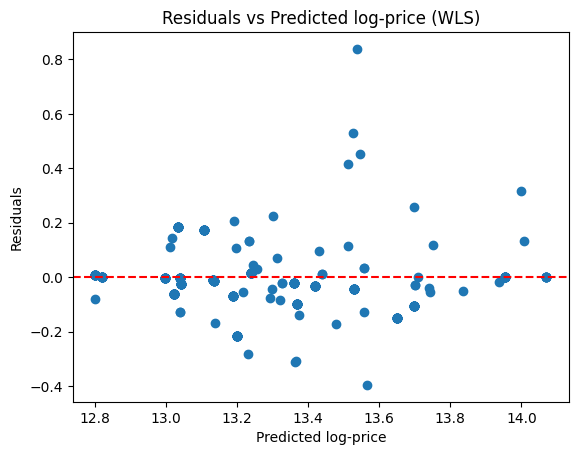

R² on log-transformed scale: 0.869
{'Test Statistic': np.float64(356.65395913330207), 'Test Statistic p-value': np.float64(1.8928818309074378e-63), 'F-Statistic': np.float64(82.64993987636208), 'F-Test p-value': np.float64(4.241218671898573e-133)}


In [15]:
# Log-transform the target variable (price)
df_encoded['log_price'] = np.log1p(df_encoded['price'])  # log(1 + price) to handle zero prices if any

# Features matrix with intercept
X_sm = sm.add_constant(df_encoded[feature_cols].astype(float))

# Target
y_log = df_encoded['log_price']

ols_log = sm.OLS(y_log, X_sm).fit()
residuals_log = ols_log.resid

residuals_log_sq = residuals_log ** 2
aux_model = sm.OLS(residuals_log_sq, X_sm).fit()
fitted_var = aux_model.fittedvalues

# Weights are inverse of estimated variance (avoid zeros)
weights = 1 / np.maximum(fitted_var, 1e-6)

wls_log = sm.WLS(y_log, X_sm, weights=weights).fit()
print(wls_log.summary())

# For train or test data X_new_sm
y_log_pred = wls_log.predict(X_sm)  # predicted log-price

# Convert back to price scale
y_pred = np.expm1(y_log_pred)  # inverse of log1p

# Evaluate y_pred vs actual price
import matplotlib.pyplot as plt

residuals_wls_log = y_log - y_log_pred
plt.scatter(y_log_pred, residuals_wls_log)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted log-price')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted log-price (WLS)')
plt.show()
# y_log: actual log-transformed target
y_log = df_encoded['log_price']

# y_pred_log: predicted log price from your WLS model
y_pred_log = wls_log.predict(X_sm)

# Calculate R² on log scale
r2_log_scale = r2_score(y_log, y_pred_log)
print(f"R² on log-transformed scale: {r2_log_scale:.3f}")

# Fit linear regression model with statsmodels to get residuals and design matrix
X_sm = sm.add_constant(X_train)  # add intercept
model_sm = sm.OLS(y_train, X_sm).fit()

residuals_wls = wls_log.resid
white_test_wls = het_white(residuals_wls, wls_log.model.exog)

labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test_wls)))

## RESULTS

The R-Squared has significantly improved.

I used log-transformed price in order to compress the larger values and try to reduce heteroscedascity. Then I proceeded to use WLS on the log-price model. I tested the corrected model for heteroscedasticity with White's test. 
Despite the attempts at correcting the model, I still had to reject the null hypothesis of homoscedasticity (F-test p-value < 0.01). 

Heteroscedasticity casues the standard errors, confidence intervals, and significance tests to be unreliable.

The model is build using a limited set of variables, which do not fully capture the full range of factors contributing to price formation. As a result, the model might systematically under- or overpredict prices for certain segments of the data, especially at the extremes. 

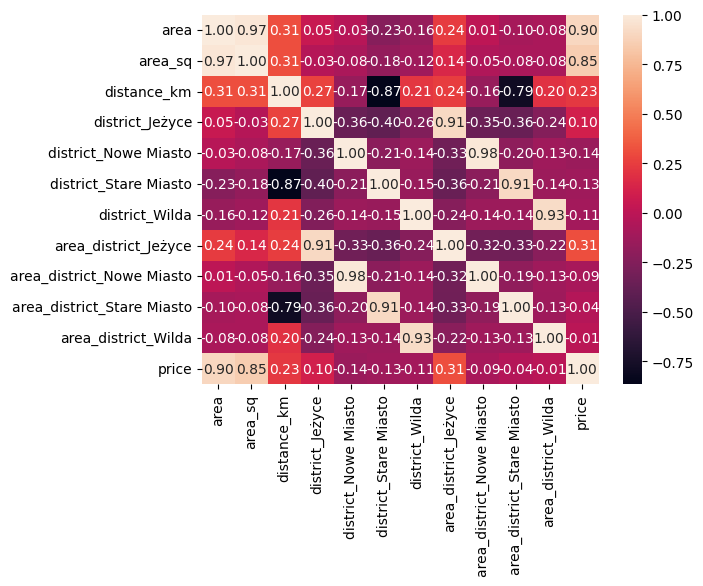

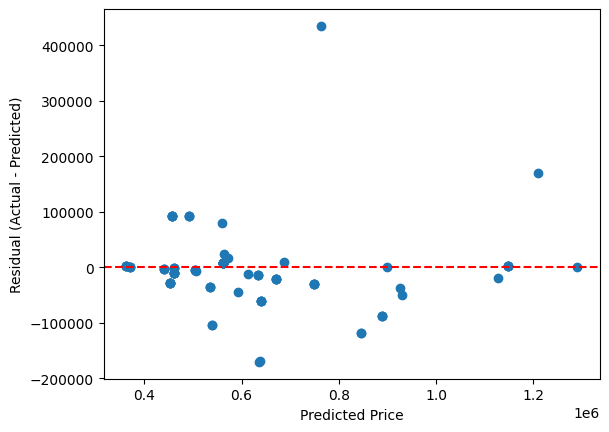

In [13]:
corr = df_encoded[feature_cols + ['price']].corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()


plt.scatter(y_pred, y_test - y_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residual (Actual - Predicted)')
plt.show()

